In [37]:
# Import the dependency
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import tensorflow as tf
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import warnings
warnings.filterwarnings('ignore')

## Read in the data

In [38]:
crypto_daily_df = pd.read_csv('Resources/crypto_daily.csv')
crypto_daily_df.head()

,date,Asset_ID,Asset_Name,Weight,Open,High,Low,Close,Volume,VWAP
0,2018-01-01,0,Binance Coin,4.304065,8.5300,8.70,7.80,8.4381,6.632793e+05,8.268735
1,2018-01-01,9,Litecoin,2.397895,225.3300,237.77,212.74,223.9000,4.791826e+05,223.977396
2,2018-01-01,6,Ethereum,5.894403,738.3025,772.98,716.80,757.3900,2.739851e+05,745.603094
3,2018-01-01,5,EOS.IO,1.386294,7.6596,7.95,7.20,7.6401,1.833038e+06,7.642579
4,2018-01-01,1,Bitcoin,6.779922,13835.1940,14442.90,12750.00,13468.6980,5.788981e+04,13439.704032


In [39]:
# create new DataFrame for each crypto asset
bnc_daily_df = crypto_daily_df.loc[crypto_daily_df["Asset_ID"]==0]
bit_daily_df = crypto_daily_df.loc[crypto_daily_df["Asset_ID"]==1]
eos_daily_df = crypto_daily_df.loc[crypto_daily_df["Asset_ID"]==5]
eth_daily_df = crypto_daily_df.loc[crypto_daily_df["Asset_ID"]==6]
lit_daily_df = crypto_daily_df.loc[crypto_daily_df["Asset_ID"]==9]
mon_daily_df = crypto_daily_df.loc[crypto_daily_df["Asset_ID"]==11]

bnc_daily_df.head()

,date,Asset_ID,Asset_Name,Weight,Open,High,Low,Close,Volume,VWAP
0,2018-01-01,0,Binance Coin,4.304065,8.530,8.7000,7.8000,8.4381,663279.30,8.268735
9,2018-01-02,0,Binance Coin,4.304065,8.463,9.1133,8.0922,8.6996,1267257.37,8.523795
16,2018-01-03,0,Binance Coin,4.304065,8.711,9.4697,8.2653,9.2880,945805.40,8.705238
22,2018-01-04,0,Binance Coin,4.304065,9.288,9.6511,8.5595,9.1215,986443.42,9.048950
26,2018-01-05,0,Binance Coin,4.304065,9.135,16.8172,8.9651,15.0045,2767053.79,11.863208


## Split training and testing data for each cryptocurrency

In [40]:
# Split training and testing data for Binance Coin
bnc_train = bnc_daily_df[0:1096] # Start from 2018-01-01 to 2021-01-01 
bnc_test = bnc_daily_df[1096:] # Start from 2021-01-01 to 2021-09-20 
X_bnc_train = bnc_train[["High", "Low", "VWAP"]]
X_bnc_test = bnc_test[["High", "Low", "VWAP"]]
y_bnc_train = bnc_train.Close
y_bnc_test = bnc_test.Close

# Split training and testing data for Bitcoin
bit_train = bit_daily_df[0:1096] # Start from 2018-01-01 to 2021-01-01 
bit_test = bit_daily_df[1096:] # Start from 2021-01-01 to 2021-09-20 
X_bit_train = bit_train[["High", "Low", "VWAP"]]
X_bit_test = bit_test[["High", "Low", "VWAP"]]
y_bit_train = bit_train.Close
y_bit_test = bit_test.Close

# Split training and testing data for EOS.IO
eos_train = eos_daily_df[0:1096] # Start from 2018-01-01 to 2021-01-01 
eos_test = eos_daily_df[1096:] # Start from 2021-01-01 to 2021-09-20 
X_eos_train = eos_train[["High", "Low", "VWAP"]]
X_eos_test = eos_test[["High", "Low", "VWAP"]]
y_eos_train = eos_train.Close
y_eos_test = eos_test.Close

# Split training and testing data for Ethereum
eth_train = eth_daily_df[0:1096] # Start from 2018-01-01 to 2021-01-01 
eth_test = eth_daily_df[1096:] # Start from 2021-01-01 to 2021-09-20 
X_eth_train = eth_train[["High", "Low", "VWAP"]]
X_eth_test = eth_test[["High", "Low", "VWAP"]]
y_eth_train = eth_train.Close
y_eth_test = eth_test.Close

# Split training and testing data for Litecoin
lit_train = lit_daily_df[0:1096] # Start from 2018-01-01 to 2021-01-01 
lit_test = lit_daily_df[1096:] # Start from 2021-01-01 to 2021-09-20 
X_lit_train = lit_train[["High", "Low", "VWAP"]]
X_lit_test = lit_test[["High", "Low", "VWAP"]]
y_lit_train = lit_train.Close
y_lit_test = lit_test.Close

# Split training and testing data for Monero
mon_train = mon_daily_df[0:1096] # Start from 2018-01-01 to 2021-01-01 
mon_test = mon_daily_df[1096:] # Start from 2021-01-01 to 2021-09-20 
X_mon_train = mon_train[["High", "Low", "VWAP"]]
X_mon_test = mon_test[["High", "Low", "VWAP"]]
y_mon_train = mon_train.Close
y_mon_test = mon_test.Close

## Scale the traning and testing data

In [41]:
# Create a StandardScaler instances
scaler = StandardScaler()
X_bnc_scaler = scaler.fit(X_bnc_train)
X_bit_scaler = scaler.fit(X_bit_train)
X_eos_scaler = scaler.fit(X_eos_train)
X_eth_scaler = scaler.fit(X_eth_train)
X_lit_scaler = scaler.fit(X_lit_train)
X_mon_scaler = scaler.fit(X_mon_train)

# Scale the data for those six cryptocurrencies
X_bnc_train_scaled = X_bnc_scaler.transform(X_bnc_train)
X_bnc_test_scaled = X_bnc_scaler.transform(X_bnc_test)

X_bit_train_scaled = X_bit_scaler.transform(X_bit_train)
X_bit_test_scaled = X_bit_scaler.transform(X_bit_test)

X_eos_train_scaled = X_eos_scaler.transform(X_eos_train)
X_eos_test_scaled = X_eos_scaler.transform(X_eos_test)

X_eth_train_scaled = X_eth_scaler.transform(X_eth_train)
X_eth_test_scaled = X_eth_scaler.transform(X_eth_test)

X_lit_train_scaled = X_lit_scaler.transform(X_lit_train)
X_lit_test_scaled = X_lit_scaler.transform(X_lit_test)

X_mon_train_scaled = X_mon_scaler.transform(X_mon_train)
X_mon_test_scaled = X_mon_scaler.transform(X_mon_test)

## Create machine learning model
### 1. LinearRegression --- baseline

In [42]:
# Train the data using LinearRegression
lr_model = LinearRegression()

lr_model.fit(X_bnc_train_scaled,y_bnc_train)
y_pred_lr_bnc = lr_model.predict(X_bnc_test_scaled)

lr_model.fit(X_bit_train_scaled,y_bit_train)
y_pred_lr_bit = lr_model.predict(X_bit_test_scaled)

lr_model.fit(X_eos_train_scaled,y_eos_train)
y_pred_lr_eos = lr_model.predict(X_eos_test_scaled)

lr_model.fit(X_eth_train_scaled,y_eth_train)
y_pred_lr_eth = lr_model.predict(X_eth_test_scaled)

lr_model.fit(X_lit_train_scaled,y_lit_train)
y_pred_lr_lit = lr_model.predict(X_lit_test_scaled)

lr_model.fit(X_mon_train_scaled,y_mon_train)
y_pred_lr_mon = lr_model.predict(X_mon_test_scaled)

In [43]:
print(f"Test Score for Binance Coin: {r2_score(y_bnc_test, y_pred_lr_bnc):.3f}")
print(f"Test Score for Bitcoin: {r2_score(y_bit_test, y_pred_lr_bit):.3f}")  
print(f"Test Score for EOS.IO: {r2_score(y_eos_test, y_pred_lr_eos):.3f}")  
print(f"Test Score for Ethereum: {r2_score(y_eth_test, y_pred_lr_eth):.3f}")  
print(f"Test Score for Litecoin: {r2_score(y_lit_test, y_pred_lr_lit):.3f}")  
print(f"Test Score for Monero: {r2_score(y_mon_test, y_pred_lr_mon):.3f}") 

Test Score for Binance Coin: 0.993
Test Score for Bitcoin: 0.985
Test Score for EOS.IO: 0.964
Test Score for Ethereum: 0.990
Test Score for Litecoin: 0.980
Test Score for Monero: 0.976


### 2. RandomForest

In [44]:
# Train the data using Random Forest
rf_model = RandomForestRegressor(n_estimators=5, 
                                min_samples_split=6, 
                                min_samples_leaf=1, 
                                max_features='auto', 
                                max_depth=110, 
                                bootstrap=True)

rf_model.fit(X_bnc_train_scaled,y_bnc_train)
y_pred_rf_bnc = rf_model.predict(X_bnc_test_scaled)

rf_model.fit(X_bit_train_scaled,y_bit_train)
y_pred_rf_bit = rf_model.predict(X_bit_test_scaled)

rf_model.fit(X_eos_train_scaled,y_eos_train)
y_pred_rf_eos = rf_model.predict(X_eos_test_scaled)

rf_model.fit(X_eth_train_scaled,y_eth_train)
y_pred_rf_eth = rf_model.predict(X_eth_test_scaled)

rf_model.fit(X_lit_train_scaled,y_lit_train)
y_pred_rf_lit = rf_model.predict(X_lit_test_scaled)

rf_model.fit(X_mon_train_scaled,y_mon_train)
y_pred_rf_mon = rf_model.predict(X_mon_test_scaled)

In [45]:
print(f"Test Score for Binance Coin: {r2_score(y_bnc_test, y_pred_rf_bnc):.3f}")
print(f"Test Score for Bitcoin: {r2_score(y_bit_test, y_pred_rf_bit):.3f}")  
print(f"Test Score for EOS.IO: {r2_score(y_eos_test, y_pred_rf_eos):.3f}")  
print(f"Test Score for Ethereum: {r2_score(y_eth_test, y_pred_rf_eth):.3f}")  
print(f"Test Score for Litecoin: {r2_score(y_lit_test, y_pred_rf_lit):.3f}")  
print(f"Test Score for Monero: {r2_score(y_mon_test, y_pred_rf_mon):.3f}") 

Test Score for Binance Coin: -3.132
Test Score for Bitcoin: -3.333
Test Score for EOS.IO: 0.958
Test Score for Ethereum: -1.803
Test Score for Litecoin: 0.889
Test Score for Monero: 0.961


In [46]:
from sklearn.inspection import permutation_importance
rf_model.feature_importances_

array([0.39842077, 0.03503793, 0.56654129])

In [47]:
# View the feature scores
feature_scores = pd.Series(rf_model.feature_importances_, index=X_bnc_train.columns).sort_values(ascending=False)
feature_scores

VWAP    0.566541
High    0.398421
Low     0.035038
dtype: float64

### Use Random Search CV to define best Hyperparameter Tuning for Random Forest

In [48]:
n_estimators = [5,20,50,100] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

In [49]:
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = rf_model,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

In [50]:
rf_random.fit(X_bnc_train_scaled, y_bnc_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; to

[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=5; total time=   0.0s[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=90, max_features=s

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(max_depth=110,
                                                   min_samples_split=6,
                                                   n_estimators=5),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      120],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 4],
                                        'min_samples_split': [2, 6, 10],
                                        'n_estimators': [5, 20, 50, 100]},
                   random_state=42, verbose=2)

In [51]:
print ('Random grid: ', random_grid, '\n')
# print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')

Random grid:  {'n_estimators': [5, 20, 50, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 20, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': False}  



### 3. XGBoost
Perhaps the most commonly configured hyperparameters are the following:
- n_estimators: The number of trees in the ensemble, often increased until no further improvements are seen.
- max_depth: The maximum depth of each tree, often values are between 1 and 10.
- eta: The learning rate used to weight each model, often set to small values such as 0.3, 0.1, 0.01, or smaller.
- subsample: The number of samples (rows) used in each tree, set to a value between 0 and 1, often 1.0 to use all samples.
- colsample_bytree: Number of features (columns) used in each tree, set to a value between 0 and 1, often 1.0 to use all features.

In [52]:
# create an xgboost regression model
xg_model = XGBRegressor(max_depth=5, 
                      objective='reg:squarederror',
                      colsample_bylevel=0.5,
                      learning_rate=0.1,
                      n_estimators=100)

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

xg_model.fit(X_bnc_train_scaled, y_bnc_train)
y_pred_xg_bnc = xg_model.predict(X_bnc_test_scaled)

xg_model.fit(X_bit_train_scaled, y_bit_train)
y_pred_xg_bit = xg_model.predict(X_bit_test_scaled)

xg_model.fit(X_eos_train_scaled, y_eos_train)
y_pred_xg_eos = xg_model.predict(X_eos_test_scaled)

xg_model.fit(X_eth_train_scaled, y_eth_train)
y_pred_xg_eth = xg_model.predict(X_eth_test_scaled)

xg_model.fit(X_lit_train_scaled, y_lit_train)
y_pred_xg_lit = xg_model.predict(X_lit_test_scaled)

xg_model.fit(X_mon_train_scaled, y_mon_train)
y_pred_xg_mon = xg_model.predict(X_mon_test_scaled)

In [53]:
print(f"Test Score for Binance Coin: {r2_score(y_bnc_test, y_pred_xg_bnc):.3f}")
print(f"Test Score for Bitcoin: {r2_score(y_bit_test, y_pred_xg_bit):.3f}")  
print(f"Test Score for EOS.IO: {r2_score(y_eos_test, y_pred_xg_eos):.3f}")  
print(f"Test Score for Ethereum: {r2_score(y_eth_test, y_pred_xg_eth):.3f}")  
print(f"Test Score for Litecoin: {r2_score(y_lit_test, y_pred_xg_lit):.3f}")  
print(f"Test Score for Monero: {r2_score(y_mon_test, y_pred_xg_mon):.3f}") 

Test Score for Binance Coin: -3.132
Test Score for Bitcoin: -2.921
Test Score for EOS.IO: 0.965
Test Score for Ethereum: -1.556
Test Score for Litecoin: 0.895
Test Score for Monero: 0.971


### 4. Artificial Neural Network
I am using two hidden layers with five neurons each and one output layer with one neuron.
- units=5: This means we are creating a layer with five neurons in it. 
- input_dim=3: This means there are 3 predictors in the input data which is expected by the first layer. 
- kernel_initializer=’normal’: When the Neurons start their computation, some algorithm has to decide the value for each weight.
- activation=’relu’: This specifies the activation function for the calculations inside each neuron. 
- batch_size=20: This specifies how many rows will be passed to the Network in one go after which the SSE calculation will begin and the neural network will start adjusting its weights based on the errors. 
- Epochs=50: The same activity of adjusting weights continues for 50 times, as specified by this parameter.

In [67]:
from keras.models import Sequential
from keras.layers import Dense
 
# create ANN model
model = Sequential()
 
# Defining the Input layer and First hidden layer
model.add(Dense(units=5, input_dim=3, kernel_initializer='normal', activation='relu'))
 
# Defining the Second layer of the model
model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))
 
# The output neuron is a single fully connected node 
# Since we will be predicting a single number
model.add(Dense(1, kernel_initializer='normal'))
 
# Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])
 
# Fitting the ANN to the Training set
model.fit(X_bnc_train_scaled, y_bnc_train, batch_size = 5,epochs = 100, verbose=1)

# Generating Predictions on testing data
y_pred_nn_bnc=model.predict(X_bnc_test_scaled)

Epoch 1/100
220/220 [==============================] - 1s 2ms/step - loss: 344.9519 - accuracy: 0.0000e+00
Epoch 2/100
220/220 [==============================] - 0s 2ms/step - loss: 180.9952 - accuracy: 0.0000e+00
Epoch 3/100
220/220 [==============================] - 0s 2ms/step - loss: 80.6864 - accuracy: 0.0000e+00
Epoch 4/100
220/220 [==============================] - 0s 2ms/step - loss: 77.3378 - accuracy: 0.0000e+00
Epoch 5/100
220/220 [==============================] - 0s 2ms/step - loss: 77.0264 - accuracy: 0.0000e+00
Epoch 6/100
220/220 [==============================] - 0s 2ms/step - loss: 76.8067 - accuracy: 0.0000e+00
Epoch 7/100
220/220 [==============================] - 0s 2ms/step - loss: 76.4386 - accuracy: 0.0000e+00
Epoch 8/100
220/220 [==============================] - 0s 2ms/step - loss: 76.0599 - accuracy: 0.0000e+00
Epoch 9/100
220/220 [==============================] - 0s 2ms/step - loss: 75.8235 - accuracy: 0.0000e+00
Epoch 10/100
220/220 [======================

In [55]:
# Fitting the ANN to the Training set
model.fit(X_bit_train_scaled, y_bit_train, batch_size = 10,epochs = 100, verbose=1)
# Generating Predictions on testing data
y_pred_nn_bit=model.predict(X_bit_test_scaled)

Epoch 1/100
110/110 [==============================] - 0s 2ms/step - loss: 60787620.0000 - accuracy: 0.0000e+00
Epoch 2/100
110/110 [==============================] - 0s 2ms/step - loss: 5909100.0000 - accuracy: 0.0000e+00
Epoch 3/100
110/110 [==============================] - 0s 2ms/step - loss: 42190.3047 - accuracy: 0.0000e+00
Epoch 4/100
110/110 [==============================] - 0s 2ms/step - loss: 37847.4258 - accuracy: 0.0000e+00
Epoch 5/100
110/110 [==============================] - 0s 2ms/step - loss: 37962.0039 - accuracy: 0.0000e+00
Epoch 6/100
110/110 [==============================] - 0s 2ms/step - loss: 37880.9961 - accuracy: 0.0000e+00
Epoch 7/100
110/110 [==============================] - 0s 2ms/step - loss: 38059.1094 - accuracy: 0.0000e+00
Epoch 8/100
110/110 [==============================] - 0s 2ms/step - loss: 37973.2773 - accuracy: 0.0000e+00
Epoch 9/100
110/110 [==============================] - 0s 2ms/step - loss: 37904.8047 - accuracy: 0.0000e+00
Epoch 10/100
1

In [56]:
# Fitting the ANN to the Training set
model.fit(X_eos_train_scaled, y_eos_train, batch_size = 10,epochs = 100, verbose=1)
# Generating Predictions on testing data
y_pred_nn_eos=model.predict(X_eos_test_scaled)

Epoch 1/100
110/110 [==============================] - 0s 2ms/step - loss: 20.5084 - accuracy: 0.0000e+00
Epoch 2/100
110/110 [==============================] - 0s 2ms/step - loss: 20.2552 - accuracy: 0.0000e+00
Epoch 3/100
110/110 [==============================] - 0s 2ms/step - loss: 20.0019 - accuracy: 0.0000e+00
Epoch 4/100
110/110 [==============================] - 0s 2ms/step - loss: 19.7400 - accuracy: 0.0000e+00
Epoch 5/100
110/110 [==============================] - 0s 2ms/step - loss: 19.4690 - accuracy: 0.0000e+00
Epoch 6/100
110/110 [==============================] - 0s 2ms/step - loss: 19.1898 - accuracy: 0.0000e+00
Epoch 7/100
110/110 [==============================] - 0s 2ms/step - loss: 18.9017 - accuracy: 0.0000e+00
Epoch 8/100
110/110 [==============================] - 0s 2ms/step - loss: 18.6064 - accuracy: 0.0000e+00
Epoch 9/100
110/110 [==============================] - 0s 2ms/step - loss: 18.3033 - accuracy: 0.0000e+00
Epoch 10/100
110/110 [========================

110/110 [==============================] - 0s 2ms/step - loss: 2.8895 - accuracy: 0.0000e+00
Epoch 79/100
110/110 [==============================] - 0s 2ms/step - loss: 2.8852 - accuracy: 0.0000e+00
Epoch 80/100
110/110 [==============================] - 0s 2ms/step - loss: 2.8846 - accuracy: 0.0000e+00
Epoch 81/100
110/110 [==============================] - 0s 2ms/step - loss: 2.8828 - accuracy: 0.0000e+00
Epoch 82/100
110/110 [==============================] - 0s 2ms/step - loss: 2.8805 - accuracy: 0.0000e+00
Epoch 83/100
110/110 [==============================] - 1s 5ms/step - loss: 2.8773 - accuracy: 0.0000e+00
Epoch 84/100
110/110 [==============================] - 0s 2ms/step - loss: 2.8774 - accuracy: 0.0000e+00
Epoch 85/100
110/110 [==============================] - 0s 2ms/step - loss: 2.8773 - accuracy: 0.0000e+00
Epoch 86/100
110/110 [==============================] - 0s 2ms/step - loss: 2.8776 - accuracy: 0.0000e+00
Epoch 87/100
110/110 [==============================] - 0s 

In [57]:
# Fitting the ANN to the Training set
model.fit(X_eth_train_scaled, y_eth_train, batch_size = 10,epochs = 100, verbose=1)
# Generating Predictions on testing data
y_pred_nn_eth=model.predict(X_eth_test_scaled)

Epoch 1/100
110/110 [==============================] - 0s 2ms/step - loss: 1104.0122 - accuracy: 0.0000e+00
Epoch 2/100
110/110 [==============================] - 0s 2ms/step - loss: 575.7443 - accuracy: 0.0000e+00
Epoch 3/100
110/110 [==============================] - 0s 2ms/step - loss: 389.2612 - accuracy: 0.0000e+00
Epoch 4/100
110/110 [==============================] - 0s 2ms/step - loss: 280.3140 - accuracy: 0.0000e+00
Epoch 5/100
110/110 [==============================] - 0s 2ms/step - loss: 216.7470 - accuracy: 0.0000e+00
Epoch 6/100
110/110 [==============================] - 0s 2ms/step - loss: 187.0669 - accuracy: 0.0000e+00
Epoch 7/100
110/110 [==============================] - 0s 2ms/step - loss: 161.1860 - accuracy: 0.0000e+00
Epoch 8/100
110/110 [==============================] - 0s 2ms/step - loss: 149.2819 - accuracy: 0.0000e+00
Epoch 9/100
110/110 [==============================] - 0s 2ms/step - loss: 144.7902 - accuracy: 0.0000e+00
Epoch 10/100
110/110 [==============

In [58]:
# Fitting the ANN to the Training set
model.fit(X_lit_train_scaled, y_lit_train, batch_size = 10,epochs = 100, verbose=1)
# Generating Predictions on testing data
y_pred_nn_lit=model.predict(X_lit_test_scaled)

Epoch 1/100
110/110 [==============================] - 0s 2ms/step - loss: 71.7651 - accuracy: 0.0000e+00
Epoch 2/100
110/110 [==============================] - 0s 2ms/step - loss: 49.1436 - accuracy: 0.0000e+00
Epoch 3/100
110/110 [==============================] - 0s 2ms/step - loss: 40.7957 - accuracy: 0.0000e+00
Epoch 4/100
110/110 [==============================] - 0s 2ms/step - loss: 35.3616 - accuracy: 0.0000e+00
Epoch 5/100
110/110 [==============================] - 0s 2ms/step - loss: 31.4648 - accuracy: 0.0000e+00
Epoch 6/100
110/110 [==============================] - 0s 2ms/step - loss: 28.6240 - accuracy: 0.0000e+00
Epoch 7/100
110/110 [==============================] - 0s 2ms/step - loss: 26.5238 - accuracy: 0.0000e+00
Epoch 8/100
110/110 [==============================] - 0s 2ms/step - loss: 24.9574 - accuracy: 0.0000e+00
Epoch 9/100
110/110 [==============================] - 0s 2ms/step - loss: 23.5533 - accuracy: 0.0000e+00
Epoch 10/100
110/110 [========================

In [59]:
# Fitting the ANN to the Training set
model.fit(X_mon_train_scaled, y_mon_train, batch_size = 10,epochs = 100, verbose=1)
# Generating Predictions on testing data
y_pred_nn_mon=model.predict(X_mon_test_scaled)

Epoch 1/100
110/110 [==============================] - 0s 2ms/step - loss: 35.6778 - accuracy: 0.0000e+00
Epoch 2/100
110/110 [==============================] - 0s 2ms/step - loss: 34.4900 - accuracy: 0.0000e+00
Epoch 3/100
110/110 [==============================] - 1s 5ms/step - loss: 34.3830 - accuracy: 0.0000e+00
Epoch 4/100
110/110 [==============================] - 0s 3ms/step - loss: 32.5624 - accuracy: 0.0000e+00
Epoch 5/100
110/110 [==============================] - 0s 3ms/step - loss: 33.7327 - accuracy: 0.0000e+00
Epoch 6/100
110/110 [==============================] - 0s 3ms/step - loss: 31.7760 - accuracy: 0.0000e+00
Epoch 7/100
110/110 [==============================] - 0s 2ms/step - loss: 31.2576 - accuracy: 0.0000e+00
Epoch 8/100
110/110 [==============================] - 0s 3ms/step - loss: 31.0533 - accuracy: 0.0000e+00
Epoch 9/100
110/110 [==============================] - 0s 2ms/step - loss: 31.1561 - accuracy: 0.0000e+00
Epoch 10/100
110/110 [========================

In [68]:
print(f"Test Score for Binance Coin: {r2_score(y_bnc_test, y_pred_nn_bnc):.3f}")
print(f"Test Score for Bitcoin: {r2_score(y_bit_test, y_pred_nn_bit):.3f}")  
print(f"Test Score for EOS.IO: {r2_score(y_eos_test, y_pred_nn_eos):.3f}")  
print(f"Test Score for Ethereum: {r2_score(y_eth_test, y_pred_nn_eth):.3f}")  
print(f"Test Score for Litecoin: {r2_score(y_lit_test, y_pred_nn_lit):.3f}")  
print(f"Test Score for Monero: {r2_score(y_mon_test, y_pred_nn_mon):.3f}") 

Test Score for Binance Coin: 0.993
Test Score for Bitcoin: 0.986
Test Score for EOS.IO: 0.694
Test Score for Ethereum: 0.990
Test Score for Litecoin: 0.980
Test Score for Monero: 0.976


### Finding best hyperparameters for Neural Network using GridSearchCV
Finding the best values for batch_size and epoch is very important as it directly affects the model performance. Bad values can lead to overfitting or underfitting. 
Apart from epoch and batch_size, you can also choose to tune the optimal number of neurons, the optimal number of layers, etc.

In [61]:
# Function to generate Deep ANN model 
def make_regression_ann(Optimizer_trial):
    from keras.models import Sequential
    from keras.layers import Dense
    
    model = Sequential()
    model.add(Dense(units=5, input_dim=3, kernel_initializer='normal', activation='relu'))
    model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer=Optimizer_trial)
    return model
 
###########################################
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
 
# Listing all the parameters to try
Parameter_Trials={'batch_size':[5,10,20],
                      'epochs':[50,100],
                    'Optimizer_trial':['adam', 'rmsprop']
                 }
 
# Creating the regression ANN model
RegModel=KerasRegressor(make_regression_ann, verbose=0)
 
###########################################
from sklearn.metrics import make_scorer
 
# Defining a custom function to calculate accuracy
def Accuracy_Score(orig,pred):
    MAPE = np.mean(100 * (np.abs(orig-pred)/orig))
    print('#'*70,'Accuracy:', 100-MAPE)
    return(100-MAPE)
 
custom_Scoring=make_scorer(Accuracy_Score, greater_is_better=True)
 
#########################################
# Creating the Grid search space
# See different scoring methods by using sklearn.metrics.SCORERS.keys()
grid_search=GridSearchCV(estimator=RegModel, 
                         param_grid=Parameter_Trials, 
                         scoring=custom_Scoring, 
                         cv=5)
 
#########################################
# Measuring how much time it took to find the best params
import time
StartTime=time.time()
 
# Running Grid Search for different paramenters
grid_search.fit(X_bnc_train_scaled,y_bnc_train, verbose=1)
 
EndTime=time.time()

Epoch 1/50
176/176 [==============================] - 1s 2ms/step - loss: 411.6492
Epoch 2/50
176/176 [==============================] - 0s 2ms/step - loss: 405.2911
Epoch 3/50
176/176 [==============================] - 0s 2ms/step - loss: 399.0469
Epoch 4/50
176/176 [==============================] - 0s 2ms/step - loss: 392.8378
Epoch 5/50
176/176 [==============================] - 0s 2ms/step - loss: 386.7299
Epoch 6/50
176/176 [==============================] - 0s 2ms/step - loss: 380.7020
Epoch 7/50
176/176 [==============================] - 0s 2ms/step - loss: 374.7447
Epoch 8/50
176/176 [==============================] - 0s 2ms/step - loss: 368.8588
Epoch 9/50
176/176 [==============================] - 0s 2ms/step - loss: 363.0563
Epoch 10/50
176/176 [==============================] - 0s 2ms/step - loss: 357.3207
Epoch 11/50
176/176 [==============================] - 0s 2ms/step - loss: 351.6780
Epoch 12/50
176/176 [==============================] - 0s 2ms/step - loss: 346.0966
E

176/176 [==============================] - 0s 2ms/step - loss: 57.3880
Epoch 49/50
176/176 [==============================] - 0s 2ms/step - loss: 57.1181
Epoch 50/50
176/176 [==============================] - 0s 2ms/step - loss: 56.9742
###################################################################### Accuracy: -54.17159843440879
Epoch 1/50
176/176 [==============================] - 1s 2ms/step - loss: 280.6414
Epoch 2/50
176/176 [==============================] - 0s 2ms/step - loss: 160.0285
Epoch 3/50
176/176 [==============================] - 0s 2ms/step - loss: 64.6511
Epoch 4/50
176/176 [==============================] - 0s 2ms/step - loss: 60.5552
Epoch 5/50
176/176 [==============================] - 0s 2ms/step - loss: 60.4700
Epoch 6/50
176/176 [==============================] - 0s 2ms/step - loss: 60.2097
Epoch 7/50
176/176 [==============================] - 0s 2ms/step - loss: 60.0171
Epoch 8/50
176/176 [==============================] - 0s 2ms/step - loss: 59.9216
Epoch

176/176 [==============================] - 0s 2ms/step - loss: 185.8409
Epoch 45/50
176/176 [==============================] - 0s 2ms/step - loss: 182.5810
Epoch 46/50
176/176 [==============================] - 0s 2ms/step - loss: 179.3806
Epoch 47/50
176/176 [==============================] - 0s 2ms/step - loss: 176.2312
Epoch 48/50
176/176 [==============================] - 0s 2ms/step - loss: 173.1323
Epoch 49/50
176/176 [==============================] - 0s 2ms/step - loss: 170.0913
Epoch 50/50
176/176 [==============================] - 0s 2ms/step - loss: 167.1029
###################################################################### Accuracy: 49.742762053631836
Epoch 1/50
176/176 [==============================] - 1s 2ms/step - loss: 290.2153
Epoch 2/50
176/176 [==============================] - 0s 2ms/step - loss: 214.8669
Epoch 3/50
176/176 [==============================] - 0s 2ms/step - loss: 98.5962
Epoch 4/50
176/176 [==============================] - 0s 2ms/step - loss: 66

176/176 [==============================] - 0s 2ms/step - loss: 75.5233
Epoch 41/100
176/176 [==============================] - 0s 2ms/step - loss: 75.0880
Epoch 42/100
176/176 [==============================] - 0s 2ms/step - loss: 74.5920
Epoch 43/100
176/176 [==============================] - 0s 2ms/step - loss: 73.9200
Epoch 44/100
176/176 [==============================] - 0s 2ms/step - loss: 73.4098
Epoch 45/100
176/176 [==============================] - 0s 2ms/step - loss: 72.7627
Epoch 46/100
176/176 [==============================] - 0s 2ms/step - loss: 72.2075
Epoch 47/100
176/176 [==============================] - 0s 2ms/step - loss: 71.6560
Epoch 48/100
176/176 [==============================] - 0s 2ms/step - loss: 70.8097
Epoch 49/100
176/176 [==============================] - 0s 2ms/step - loss: 70.0817
Epoch 50/100
176/176 [==============================] - 0s 2ms/step - loss: 69.3851
Epoch 51/100
176/176 [==============================] - 0s 2ms/step - loss: 68.3176
Epoch

 12/176 [=>............................] - ETA: 0s - loss: 33.1855n_estimators=20; total time=   0.1s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.9s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.8s
[CV] END bootstrap=False, max_depth=120, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=120, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_l

101/176 [================>.............] - ETA: 0s - loss: 38.5233
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimato

176/176 [==============================] - 0s 3ms/step - loss: 40.7327
Epoch 97/100
 18/176 [==>...........................] - ETA: 0s - loss: 37.3401
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_dept

135/176 [======================>.......] - ETA: 0s - loss: 40.5767
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=5; to

176/176 [==============================] - 0s 2ms/step - loss: 39.7834
Epoch 98/100
176/176 [==============================] - 0s 2ms/step - loss: 38.8017
Epoch 99/100
176/176 [==============================] - 0s 2ms/step - loss: 37.8028
Epoch 100/100
176/176 [==============================] - 0s 2ms/step - loss: 36.7014
###################################################################### Accuracy: -23.123061349349086
Epoch 1/100
176/176 [==============================] - 1s 2ms/step - loss: 279.5911
Epoch 2/100
176/176 [==============================] - 0s 2ms/step - loss: 146.9494
Epoch 3/100
176/176 [==============================] - 0s 2ms/step - loss: 61.9869
Epoch 4/100
176/176 [==============================] - 0s 2ms/step - loss: 60.3980
Epoch 5/100
176/176 [==============================] - 0s 2ms/step - loss: 60.2575
Epoch 6/100
176/176 [==============================] - 0s 2ms/step - loss: 59.9709
Epoch 7/100
176/176 [==============================] - 0s 2ms/step - loss: 

176/176 [==============================] - 0s 2ms/step - loss: 1.4584
Epoch 90/100
176/176 [==============================] - 0s 2ms/step - loss: 1.2079
Epoch 91/100
176/176 [==============================] - 0s 2ms/step - loss: 1.0052
Epoch 92/100
176/176 [==============================] - 0s 2ms/step - loss: 0.8515
Epoch 93/100
176/176 [==============================] - 0s 2ms/step - loss: 0.7219
Epoch 94/100
176/176 [==============================] - 0s 2ms/step - loss: 0.6224
Epoch 95/100
176/176 [==============================] - 0s 2ms/step - loss: 0.5503
Epoch 96/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4793
Epoch 97/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4406
Epoch 98/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4157
Epoch 99/100
176/176 [==============================] - 1s 3ms/step - loss: 0.3737
Epoch 100/100
176/176 [==============================] - 0s 2ms/step - loss: 0.3554
################

88/88 [==============================] - 0s 2ms/step - loss: 62.7204
Epoch 34/50
88/88 [==============================] - 0s 2ms/step - loss: 62.5909
Epoch 35/50
88/88 [==============================] - 0s 2ms/step - loss: 62.4233
Epoch 36/50
88/88 [==============================] - 0s 2ms/step - loss: 62.2638
Epoch 37/50
88/88 [==============================] - 0s 2ms/step - loss: 62.1715
Epoch 38/50
88/88 [==============================] - 0s 2ms/step - loss: 61.9823
Epoch 39/50
88/88 [==============================] - 0s 2ms/step - loss: 61.8490
Epoch 40/50
88/88 [==============================] - 0s 2ms/step - loss: 61.7929
Epoch 41/50
88/88 [==============================] - 0s 2ms/step - loss: 61.5388
Epoch 42/50
88/88 [==============================] - 0s 2ms/step - loss: 61.3803
Epoch 43/50
88/88 [==============================] - 0s 2ms/step - loss: 61.1997
Epoch 44/50
88/88 [==============================] - 0s 2ms/step - loss: 61.0596
Epoch 45/50
88/88 [=====================

88/88 [==============================] - 0s 2ms/step - loss: 84.3050
Epoch 30/100
88/88 [==============================] - 0s 2ms/step - loss: 84.0735
Epoch 31/100
88/88 [==============================] - 0s 2ms/step - loss: 83.9297
Epoch 32/100
88/88 [==============================] - 0s 2ms/step - loss: 83.6374
Epoch 33/100
88/88 [==============================] - 0s 2ms/step - loss: 83.5463
Epoch 34/100
88/88 [==============================] - 0s 2ms/step - loss: 83.2540
Epoch 35/100
88/88 [==============================] - 0s 2ms/step - loss: 82.9861
Epoch 36/100
88/88 [==============================] - 0s 2ms/step - loss: 82.7567
Epoch 37/100
88/88 [==============================] - 0s 2ms/step - loss: 82.6178
Epoch 38/100
88/88 [==============================] - 0s 2ms/step - loss: 82.4116
Epoch 39/100
88/88 [==============================] - 0s 2ms/step - loss: 82.2334
Epoch 40/100
88/88 [==============================] - 0s 2ms/step - loss: 82.0107
Epoch 41/100
88/88 [=========

88/88 [==============================] - 0s 2ms/step - loss: 58.2159
Epoch 26/100
88/88 [==============================] - 0s 2ms/step - loss: 58.1640
Epoch 27/100
88/88 [==============================] - 0s 2ms/step - loss: 58.0544
Epoch 28/100
88/88 [==============================] - 0s 2ms/step - loss: 57.9278
Epoch 29/100
88/88 [==============================] - 0s 2ms/step - loss: 57.8710
Epoch 30/100
88/88 [==============================] - 0s 2ms/step - loss: 57.7427
Epoch 31/100
88/88 [==============================] - 0s 2ms/step - loss: 57.6711
Epoch 32/100
88/88 [==============================] - 0s 2ms/step - loss: 57.5507
Epoch 33/100
88/88 [==============================] - 0s 2ms/step - loss: 57.5232
Epoch 34/100
88/88 [==============================] - 0s 2ms/step - loss: 57.3689
Epoch 35/100
88/88 [==============================] - 0s 2ms/step - loss: 57.3517
Epoch 36/100
88/88 [==============================] - 0s 2ms/step - loss: 57.2148
Epoch 37/100
88/88 [=========

88/88 [==============================] - 0s 2ms/step - loss: 63.3302
Epoch 22/100
88/88 [==============================] - 0s 2ms/step - loss: 63.2636
Epoch 23/100
88/88 [==============================] - 0s 2ms/step - loss: 63.1396
Epoch 24/100
88/88 [==============================] - 0s 2ms/step - loss: 63.0531
Epoch 25/100
88/88 [==============================] - 0s 2ms/step - loss: 63.0109
Epoch 26/100
88/88 [==============================] - 0s 2ms/step - loss: 62.9456
Epoch 27/100
88/88 [==============================] - 0s 2ms/step - loss: 62.8129
Epoch 28/100
88/88 [==============================] - 0s 2ms/step - loss: 62.7589
Epoch 29/100
88/88 [==============================] - 0s 2ms/step - loss: 62.6676
Epoch 30/100
88/88 [==============================] - 0s 2ms/step - loss: 62.5639
Epoch 31/100
88/88 [==============================] - 0s 2ms/step - loss: 62.4541
Epoch 32/100
88/88 [==============================] - 0s 2ms/step - loss: 62.3800
Epoch 33/100
88/88 [=========

44/44 [==============================] - 0s 2ms/step - loss: 87.0944
Epoch 21/50
44/44 [==============================] - 0s 2ms/step - loss: 87.0213
Epoch 22/50
44/44 [==============================] - 0s 2ms/step - loss: 86.9406
Epoch 23/50
44/44 [==============================] - 0s 2ms/step - loss: 86.8561
Epoch 24/50
44/44 [==============================] - 0s 2ms/step - loss: 86.7670
Epoch 25/50
44/44 [==============================] - 0s 2ms/step - loss: 86.6776
Epoch 26/50
44/44 [==============================] - 0s 2ms/step - loss: 86.6176
Epoch 27/50
44/44 [==============================] - 0s 3ms/step - loss: 86.5336
Epoch 28/50
44/44 [==============================] - 0s 2ms/step - loss: 86.4503
Epoch 29/50
44/44 [==============================] - 0s 2ms/step - loss: 86.4046
Epoch 30/50
44/44 [==============================] - 0s 2ms/step - loss: 86.2465
Epoch 31/50
44/44 [==============================] - 0s 2ms/step - loss: 86.1850
Epoch 32/50
44/44 [=====================

44/44 [==============================] - 0s 2ms/step - loss: 64.9365
Epoch 17/50
44/44 [==============================] - 0s 2ms/step - loss: 64.9217
Epoch 18/50
44/44 [==============================] - 0s 2ms/step - loss: 64.8749
Epoch 19/50
44/44 [==============================] - 0s 2ms/step - loss: 64.8140
Epoch 20/50
44/44 [==============================] - 0s 2ms/step - loss: 64.7572
Epoch 21/50
44/44 [==============================] - 0s 2ms/step - loss: 64.7126
Epoch 22/50
44/44 [==============================] - 0s 2ms/step - loss: 64.7056
Epoch 23/50
44/44 [==============================] - 0s 2ms/step - loss: 64.6339
Epoch 24/50
44/44 [==============================] - 0s 2ms/step - loss: 64.5608
Epoch 25/50
44/44 [==============================] - 0s 2ms/step - loss: 64.5727
Epoch 26/50
44/44 [==============================] - 0s 2ms/step - loss: 64.5098
Epoch 27/50
44/44 [==============================] - 0s 2ms/step - loss: 64.4233
Epoch 28/50
44/44 [=====================

44/44 [==============================] - 0s 2ms/step - loss: 64.0453
Epoch 64/100
44/44 [==============================] - 0s 2ms/step - loss: 64.0113
Epoch 65/100
44/44 [==============================] - 0s 2ms/step - loss: 63.9735
Epoch 66/100
44/44 [==============================] - 0s 2ms/step - loss: 63.9277
Epoch 67/100
44/44 [==============================] - 0s 2ms/step - loss: 63.9011
Epoch 68/100
44/44 [==============================] - 0s 2ms/step - loss: 63.8274
Epoch 69/100
44/44 [==============================] - 0s 2ms/step - loss: 63.8011
Epoch 70/100
44/44 [==============================] - 0s 2ms/step - loss: 63.7817
Epoch 71/100
44/44 [==============================] - 0s 2ms/step - loss: 63.7075
Epoch 72/100
44/44 [==============================] - 0s 2ms/step - loss: 63.6333
Epoch 73/100
44/44 [==============================] - 0s 2ms/step - loss: 63.5729
Epoch 74/100
44/44 [==============================] - 0s 2ms/step - loss: 63.5249
Epoch 75/100
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 304.3268
Epoch 59/100
44/44 [==============================] - 0s 2ms/step - loss: 303.0552
Epoch 60/100
44/44 [==============================] - 0s 2ms/step - loss: 301.7938
Epoch 61/100
44/44 [==============================] - 0s 2ms/step - loss: 300.5342
Epoch 62/100
44/44 [==============================] - 0s 3ms/step - loss: 299.2783
Epoch 63/100
44/44 [==============================] - 0s 2ms/step - loss: 298.0282
Epoch 64/100
44/44 [==============================] - 0s 2ms/step - loss: 296.7790
Epoch 65/100
44/44 [==============================] - 0s 2ms/step - loss: 295.5370
Epoch 66/100
44/44 [==============================] - 0s 2ms/step - loss: 294.2991
Epoch 67/100
44/44 [==============================] - 0s 2ms/step - loss: 293.0674
Epoch 68/100
44/44 [==============================] - 0s 2ms/step - loss: 291.8311
Epoch 69/100
44/44 [==============================] - 0s 2ms/step - loss: 290.6055
Epoch 70/100
44/4

176/176 [==============================] - 0s 2ms/step - loss: 269.6818
Epoch 4/50
176/176 [==============================] - 0s 2ms/step - loss: 139.2379
Epoch 5/50
176/176 [==============================] - 0s 2ms/step - loss: 70.7688
Epoch 6/50
176/176 [==============================] - 0s 2ms/step - loss: 65.2898
Epoch 7/50
176/176 [==============================] - 0s 2ms/step - loss: 64.9616
Epoch 8/50
176/176 [==============================] - 0s 2ms/step - loss: 64.7379
Epoch 9/50
176/176 [==============================] - 0s 2ms/step - loss: 64.5709
Epoch 10/50
176/176 [==============================] - 0s 2ms/step - loss: 64.3519
Epoch 11/50
176/176 [==============================] - 0s 2ms/step - loss: 64.0916
Epoch 12/50
176/176 [==============================] - 0s 2ms/step - loss: 63.9210
Epoch 13/50
176/176 [==============================] - 0s 2ms/step - loss: 63.7318
Epoch 14/50
176/176 [==============================] - 0s 2ms/step - loss: 63.5027
Epoch 15/50
176/176 

176/176 [==============================] - 0s 2ms/step - loss: 54.8835
Epoch 47/50
176/176 [==============================] - 0s 2ms/step - loss: 54.5431
Epoch 48/50
176/176 [==============================] - 0s 2ms/step - loss: 54.1111
Epoch 49/50
176/176 [==============================] - 0s 2ms/step - loss: 53.6646
Epoch 50/50
176/176 [==============================] - 0s 2ms/step - loss: 53.2293
###################################################################### Accuracy: 68.23193214161994
Epoch 1/100
176/176 [==============================] - 1s 2ms/step - loss: 407.5370
Epoch 2/100
176/176 [==============================] - 0s 2ms/step - loss: 378.5023
Epoch 3/100
176/176 [==============================] - 0s 2ms/step - loss: 319.4369
Epoch 4/100
176/176 [==============================] - 0s 2ms/step - loss: 231.2240
Epoch 5/100
176/176 [==============================] - 0s 2ms/step - loss: 141.5728
Epoch 6/100
176/176 [==============================] - 0s 2ms/step - loss: 94.

176/176 [==============================] - 0s 2ms/step - loss: 33.7341
Epoch 89/100
176/176 [==============================] - 0s 2ms/step - loss: 32.1399
Epoch 90/100
176/176 [==============================] - 0s 2ms/step - loss: 30.2791
Epoch 91/100
176/176 [==============================] - 0s 2ms/step - loss: 28.4549
Epoch 92/100
176/176 [==============================] - 0s 2ms/step - loss: 26.3829
Epoch 93/100
176/176 [==============================] - 0s 2ms/step - loss: 23.9819
Epoch 94/100
176/176 [==============================] - 0s 2ms/step - loss: 21.5633
Epoch 95/100
176/176 [==============================] - 0s 2ms/step - loss: 18.9880
Epoch 96/100
176/176 [==============================] - 0s 2ms/step - loss: 16.1455
Epoch 97/100
176/176 [==============================] - 0s 2ms/step - loss: 13.3725
Epoch 98/100
176/176 [==============================] - 0s 2ms/step - loss: 10.4824
Epoch 99/100
176/176 [==============================] - 0s 2ms/step - loss: 7.7965
Epoch 

176/176 [==============================] - 0s 2ms/step - loss: 77.1001
Epoch 81/100
176/176 [==============================] - 0s 2ms/step - loss: 76.9053
Epoch 82/100
176/176 [==============================] - 0s 2ms/step - loss: 76.6264
Epoch 83/100
176/176 [==============================] - 0s 2ms/step - loss: 76.2891
Epoch 84/100
176/176 [==============================] - 0s 2ms/step - loss: 76.0112
Epoch 85/100
176/176 [==============================] - 0s 2ms/step - loss: 75.7231
Epoch 86/100
176/176 [==============================] - 0s 2ms/step - loss: 75.4269
Epoch 87/100
176/176 [==============================] - 0s 2ms/step - loss: 75.0833
Epoch 88/100
176/176 [==============================] - 0s 2ms/step - loss: 74.8092
Epoch 89/100
176/176 [==============================] - 0s 2ms/step - loss: 74.4621
Epoch 90/100
176/176 [==============================] - 0s 2ms/step - loss: 74.1669
Epoch 91/100
176/176 [==============================] - 0s 2ms/step - loss: 73.7290
Epoch

Epoch 24/50
88/88 [==============================] - 0s 2ms/step - loss: 64.5227
Epoch 25/50
88/88 [==============================] - 0s 2ms/step - loss: 64.3953
Epoch 26/50
88/88 [==============================] - 0s 2ms/step - loss: 64.2978
Epoch 27/50
88/88 [==============================] - 0s 2ms/step - loss: 64.2391
Epoch 28/50
88/88 [==============================] - 0s 2ms/step - loss: 64.1578
Epoch 29/50
88/88 [==============================] - 0s 2ms/step - loss: 64.0598
Epoch 30/50
88/88 [==============================] - 0s 2ms/step - loss: 63.9397
Epoch 31/50
88/88 [==============================] - 0s 2ms/step - loss: 63.8067
Epoch 32/50
88/88 [==============================] - 0s 2ms/step - loss: 63.7161
Epoch 33/50
88/88 [==============================] - 0s 2ms/step - loss: 63.6179
Epoch 34/50
88/88 [==============================] - 0s 2ms/step - loss: 63.5431
Epoch 35/50
88/88 [==============================] - 0s 2ms/step - loss: 63.4340
Epoch 36/50
88/88 [=========

88/88 [==============================] - 0s 2ms/step - loss: 85.8577
Epoch 21/100
88/88 [==============================] - 0s 2ms/step - loss: 85.6601
Epoch 22/100
88/88 [==============================] - 0s 2ms/step - loss: 85.6053
Epoch 23/100
88/88 [==============================] - 0s 2ms/step - loss: 85.4742
Epoch 24/100
88/88 [==============================] - 0s 2ms/step - loss: 85.2925
Epoch 25/100
88/88 [==============================] - 0s 2ms/step - loss: 85.1912
Epoch 26/100
88/88 [==============================] - 0s 2ms/step - loss: 84.9914
Epoch 27/100
88/88 [==============================] - 0s 2ms/step - loss: 84.8769
Epoch 28/100
88/88 [==============================] - 0s 2ms/step - loss: 84.7146
Epoch 29/100
88/88 [==============================] - 0s 2ms/step - loss: 84.5828
Epoch 30/100
88/88 [==============================] - 0s 2ms/step - loss: 84.3811
Epoch 31/100
88/88 [==============================] - 0s 2ms/step - loss: 84.2126
Epoch 32/100
88/88 [=========

88/88 [==============================] - 0s 2ms/step - loss: 253.0381
Epoch 17/100
88/88 [==============================] - 0s 2ms/step - loss: 250.5638
Epoch 18/100
88/88 [==============================] - 0s 2ms/step - loss: 248.0962
Epoch 19/100
88/88 [==============================] - 0s 2ms/step - loss: 245.6344
Epoch 20/100
88/88 [==============================] - 0s 2ms/step - loss: 243.2066
Epoch 21/100
88/88 [==============================] - 0s 2ms/step - loss: 240.7891
Epoch 22/100
88/88 [==============================] - 0s 2ms/step - loss: 238.3772
Epoch 23/100
88/88 [==============================] - 0s 2ms/step - loss: 235.9943
Epoch 24/100
88/88 [==============================] - 0s 2ms/step - loss: 233.6110
Epoch 25/100
88/88 [==============================] - 0s 2ms/step - loss: 231.2516
Epoch 26/100
88/88 [==============================] - 0s 2ms/step - loss: 228.9077
Epoch 27/100
88/88 [==============================] - 0s 2ms/step - loss: 226.5823
Epoch 28/100
88/8

88/88 [==============================] - 0s 2ms/step - loss: 64.4596
Epoch 12/100
88/88 [==============================] - 0s 2ms/step - loss: 64.3068
Epoch 13/100
88/88 [==============================] - 0s 2ms/step - loss: 64.1828
Epoch 14/100
88/88 [==============================] - 0s 2ms/step - loss: 64.0017
Epoch 15/100
88/88 [==============================] - 0s 2ms/step - loss: 63.9076
Epoch 16/100
88/88 [==============================] - 0s 2ms/step - loss: 63.7870
Epoch 17/100
88/88 [==============================] - 0s 2ms/step - loss: 63.6411
Epoch 18/100
88/88 [==============================] - 0s 2ms/step - loss: 63.5347
Epoch 19/100
88/88 [==============================] - 0s 2ms/step - loss: 63.3656
Epoch 20/100
88/88 [==============================] - 0s 2ms/step - loss: 63.1772
Epoch 21/100
88/88 [==============================] - 0s 2ms/step - loss: 62.9308
Epoch 22/100
88/88 [==============================] - 0s 2ms/step - loss: 62.9546
Epoch 23/100
88/88 [=========

Epoch 10/50
44/44 [==============================] - 0s 2ms/step - loss: 255.6753
Epoch 11/50
44/44 [==============================] - 0s 2ms/step - loss: 221.0317
Epoch 12/50
44/44 [==============================] - 0s 2ms/step - loss: 186.3364
Epoch 13/50
44/44 [==============================] - 0s 2ms/step - loss: 153.2383
Epoch 14/50
44/44 [==============================] - 0s 2ms/step - loss: 124.8019
Epoch 15/50
44/44 [==============================] - 0s 2ms/step - loss: 103.2939
Epoch 16/50
44/44 [==============================] - 0s 2ms/step - loss: 91.6991
Epoch 17/50
44/44 [==============================] - 0s 2ms/step - loss: 88.0340
Epoch 18/50
44/44 [==============================] - 0s 2ms/step - loss: 87.5809
Epoch 19/50
44/44 [==============================] - 0s 2ms/step - loss: 87.3779
Epoch 20/50
44/44 [==============================] - 0s 2ms/step - loss: 87.2656
Epoch 21/50
44/44 [==============================] - 0s 2ms/step - loss: 87.0930
Epoch 22/50
44/44 [===

44/44 [==============================] - 0s 2ms/step - loss: 290.3232
Epoch 7/50
44/44 [==============================] - 0s 2ms/step - loss: 288.1511
Epoch 8/50
44/44 [==============================] - 0s 2ms/step - loss: 285.8520
Epoch 9/50
44/44 [==============================] - 0s 3ms/step - loss: 283.4654
Epoch 10/50
44/44 [==============================] - 0s 2ms/step - loss: 280.9556
Epoch 11/50
44/44 [==============================] - 0s 2ms/step - loss: 278.3651
Epoch 12/50
44/44 [==============================] - 0s 2ms/step - loss: 275.6471
Epoch 13/50
44/44 [==============================] - 0s 2ms/step - loss: 272.8466
Epoch 14/50
44/44 [==============================] - 0s 2ms/step - loss: 269.9287
Epoch 15/50
44/44 [==============================] - 0s 2ms/step - loss: 266.9516
Epoch 16/50
44/44 [==============================] - 0s 2ms/step - loss: 263.8585
Epoch 17/50
44/44 [==============================] - 0s 2ms/step - loss: 260.6815
Epoch 18/50
44/44 [============

44/44 [==============================] - 0s 2ms/step - loss: 62.5675
Epoch 53/100
44/44 [==============================] - 0s 2ms/step - loss: 62.5279
Epoch 54/100
44/44 [==============================] - 0s 2ms/step - loss: 62.3940
Epoch 55/100
44/44 [==============================] - 0s 2ms/step - loss: 62.2770
Epoch 56/100
44/44 [==============================] - 0s 2ms/step - loss: 62.1959
Epoch 57/100
44/44 [==============================] - 0s 2ms/step - loss: 62.0990
Epoch 58/100
44/44 [==============================] - 0s 2ms/step - loss: 61.9860
Epoch 59/100
44/44 [==============================] - 0s 2ms/step - loss: 61.9431
Epoch 60/100
44/44 [==============================] - 0s 2ms/step - loss: 61.8518
Epoch 61/100
44/44 [==============================] - 0s 2ms/step - loss: 61.7562
Epoch 62/100
44/44 [==============================] - 0s 2ms/step - loss: 61.6464
Epoch 63/100
44/44 [==============================] - 0s 2ms/step - loss: 61.5666
Epoch 64/100
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 89.7338
Epoch 49/100
44/44 [==============================] - 0s 2ms/step - loss: 89.6217
Epoch 50/100
44/44 [==============================] - 0s 2ms/step - loss: 89.5059
Epoch 51/100
44/44 [==============================] - 0s 2ms/step - loss: 89.4246
Epoch 52/100
44/44 [==============================] - 0s 4ms/step - loss: 89.3253
Epoch 53/100
44/44 [==============================] - 0s 3ms/step - loss: 89.2548
Epoch 54/100
44/44 [==============================] - 0s 2ms/step - loss: 89.1747
Epoch 55/100
44/44 [==============================] - 0s 2ms/step - loss: 89.0659
Epoch 56/100
44/44 [==============================] - 0s 2ms/step - loss: 88.9930
Epoch 57/100
44/44 [==============================] - 0s 2ms/step - loss: 88.8909
Epoch 58/100
44/44 [==============================] - 0s 2ms/step - loss: 88.7996
Epoch 59/100
44/44 [==============================] - 0s 2ms/step - loss: 88.6865
Epoch 60/100
44/44 [=========

220/220 [==============================] - 0s 2ms/step - loss: 66.7341
Epoch 44/100
220/220 [==============================] - 0s 2ms/step - loss: 66.3446
Epoch 45/100
220/220 [==============================] - 0s 2ms/step - loss: 65.9518
Epoch 46/100
220/220 [==============================] - 0s 2ms/step - loss: 65.6000
Epoch 47/100
220/220 [==============================] - 0s 2ms/step - loss: 65.2380
Epoch 48/100
220/220 [==============================] - 0s 2ms/step - loss: 64.8436
Epoch 49/100
220/220 [==============================] - 0s 2ms/step - loss: 64.3012
Epoch 50/100
220/220 [==============================] - 0s 2ms/step - loss: 64.0619
Epoch 51/100
220/220 [==============================] - 0s 2ms/step - loss: 63.6118
Epoch 52/100
220/220 [==============================] - 0s 2ms/step - loss: 63.0509
Epoch 53/100
220/220 [==============================] - 0s 2ms/step - loss: 62.5680
Epoch 54/100
220/220 [==============================] - 0s 2ms/step - loss: 62.1405
Epoch

In [62]:
print("########## Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes')
 
print('### Printing Best parameters ###')
grid_search.best_params_

########## Total Time Taken:  16 Minutes
### Printing Best parameters ###


{'Optimizer_trial': 'rmsprop', 'batch_size': 5, 'epochs': 100}

## Data visualisation

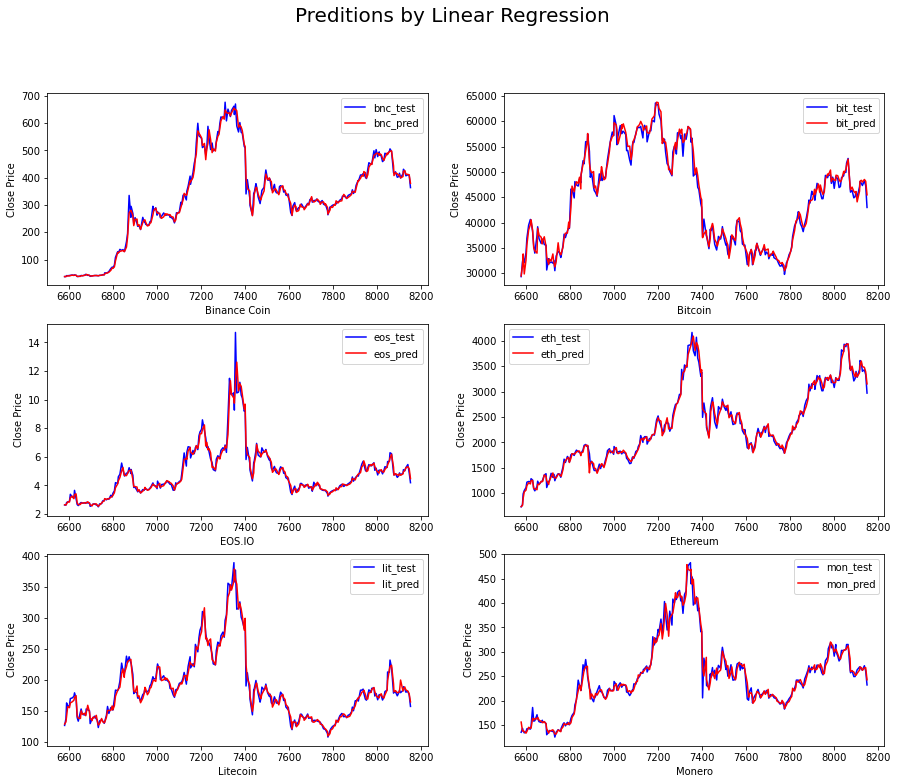

In [63]:
# visualize the prediction of lineargression for each cryptocurrency in 2021
fig = plt.figure(figsize=(15,12))
times = bnc_test.index
fig.add_subplot(321)
plt.plot(times, y_bnc_test, 'b', label='bnc_test')
plt.plot(times, y_pred_lr_bnc, 'r', label='bnc_pred')
plt.legend()
plt.xlabel('Binance Coin')
plt.ylabel('Close Price')

fig.add_subplot(322)
plt.plot(times, y_bit_test, 'b', label='bit_test')
plt.plot(times, y_pred_lr_bit, 'r', label='bit_pred')
plt.legend()
plt.xlabel('Bitcoin')
plt.ylabel('Close Price')

fig.add_subplot(323)
plt.plot(times, y_eos_test, 'b', label='eos_test')
plt.plot(times, y_pred_lr_eos, 'r', label='eos_pred')
plt.legend()
plt.xlabel('EOS.IO')
plt.ylabel('Close Price')

fig.add_subplot(324)
plt.plot(times, y_eth_test, 'b', label='eth_test')
plt.plot(times, y_pred_lr_eth, 'r', label='eth_pred')
plt.legend()
plt.xlabel('Ethereum')
plt.ylabel('Close Price')

fig.add_subplot(325)
plt.plot(times, y_lit_test, 'b', label='lit_test')
plt.plot(times, y_pred_lr_lit, 'r', label='lit_pred')
plt.legend()
plt.xlabel('Litecoin')
plt.ylabel('Close Price')

fig.add_subplot(326)
plt.plot(times, y_mon_test, 'b', label='mon_test')
plt.plot(times, y_pred_lr_mon, 'r', label='mon_pred')
plt.legend()
plt.xlabel('Monero')
plt.ylabel('Close Price')

plt.suptitle('Preditions by Linear Regression',fontsize=20)
plt.show()

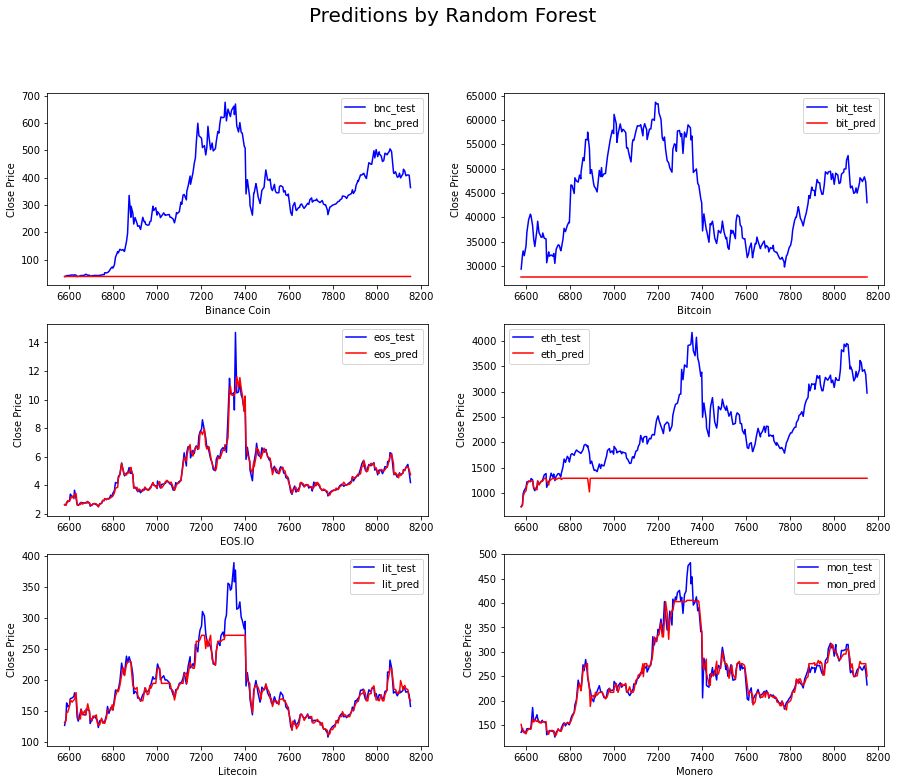

In [64]:
# visualize the prediction of randomforest for each cryptocurrency in 2021
fig = plt.figure(figsize=(15,12))
fig.add_subplot(321)
plt.plot(times, y_bnc_test, 'b', label='bnc_test')
plt.plot(times, y_pred_rf_bnc, 'r', label='bnc_pred')
plt.legend()
plt.xlabel('Binance Coin')
plt.ylabel('Close Price')

fig.add_subplot(322)
plt.plot(times, y_bit_test, 'b', label='bit_test')
plt.plot(times, y_pred_rf_bit, 'r', label='bit_pred')
plt.legend()
plt.xlabel('Bitcoin')
plt.ylabel('Close Price')

fig.add_subplot(323)
plt.plot(times, y_eos_test, 'b', label='eos_test')
plt.plot(times, y_pred_rf_eos, 'r', label='eos_pred')
plt.legend()
plt.xlabel('EOS.IO')
plt.ylabel('Close Price')

fig.add_subplot(324)
plt.plot(times, y_eth_test, 'b', label='eth_test')
plt.plot(times, y_pred_rf_eth, 'r', label='eth_pred')
plt.legend()
plt.xlabel('Ethereum')
plt.ylabel('Close Price')

fig.add_subplot(325)
plt.plot(times, y_lit_test, 'b', label='lit_test')
plt.plot(times, y_pred_rf_lit, 'r', label='lit_pred')
plt.legend()
plt.xlabel('Litecoin')
plt.ylabel('Close Price')

fig.add_subplot(326)
plt.plot(times, y_mon_test, 'b', label='mon_test')
plt.plot(times, y_pred_rf_mon, 'r', label='mon_pred')
plt.legend()
plt.xlabel('Monero')
plt.ylabel('Close Price')

plt.suptitle('Preditions by Random Forest',fontsize=20)
plt.show()

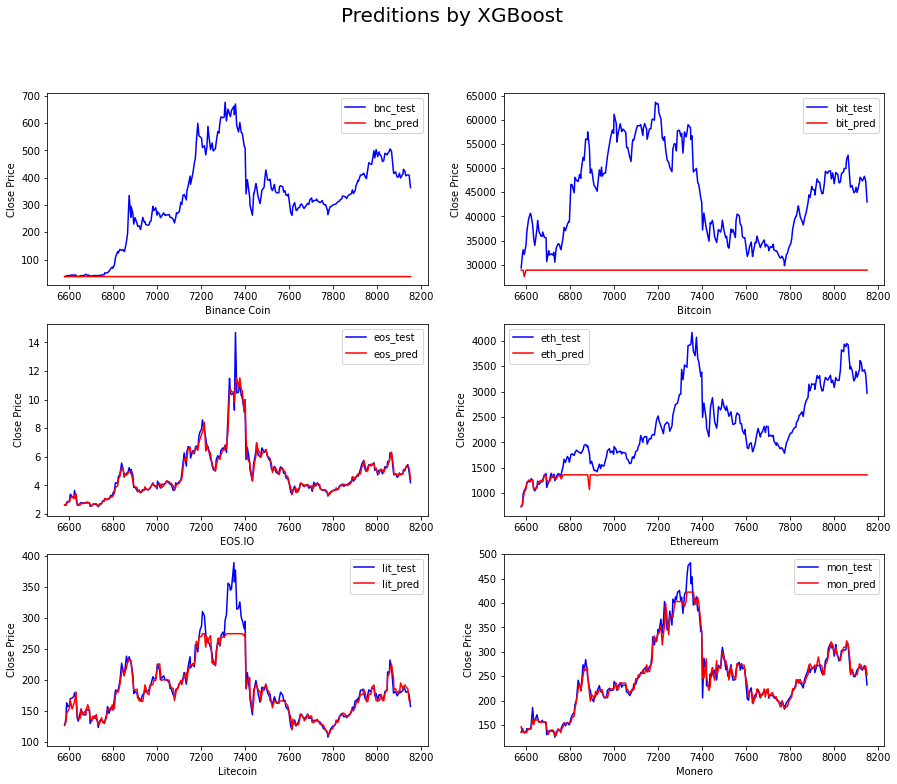

In [65]:
# visualize the prediction of xgBoost for each cryptocurrency in 2021
fig = plt.figure(figsize=(15,12))
fig.add_subplot(321)
plt.plot(times, y_bnc_test, 'b', label='bnc_test')
plt.plot(times, y_pred_xg_bnc, 'r', label='bnc_pred')
plt.legend()
plt.xlabel('Binance Coin')
plt.ylabel('Close Price')

fig.add_subplot(322)
plt.plot(times, y_bit_test, 'b', label='bit_test')
plt.plot(times, y_pred_xg_bit, 'r', label='bit_pred')
plt.legend()
plt.xlabel('Bitcoin')
plt.ylabel('Close Price')

fig.add_subplot(323)
plt.plot(times, y_eos_test, 'b', label='eos_test')
plt.plot(times, y_pred_xg_eos, 'r', label='eos_pred')
plt.legend()
plt.xlabel('EOS.IO')
plt.ylabel('Close Price')

fig.add_subplot(324)
plt.plot(times, y_eth_test, 'b', label='eth_test')
plt.plot(times, y_pred_xg_eth, 'r', label='eth_pred')
plt.legend()
plt.xlabel('Ethereum')
plt.ylabel('Close Price')

fig.add_subplot(325)
plt.plot(times, y_lit_test, 'b', label='lit_test')
plt.plot(times, y_pred_xg_lit, 'r', label='lit_pred')
plt.legend()
plt.xlabel('Litecoin')
plt.ylabel('Close Price')

fig.add_subplot(326)
plt.plot(times, y_mon_test, 'b', label='mon_test')
plt.plot(times, y_pred_xg_mon, 'r', label='mon_pred')
plt.legend()
plt.xlabel('Monero')
plt.ylabel('Close Price')

plt.suptitle('Preditions by XGBoost',fontsize=20)
plt.show()

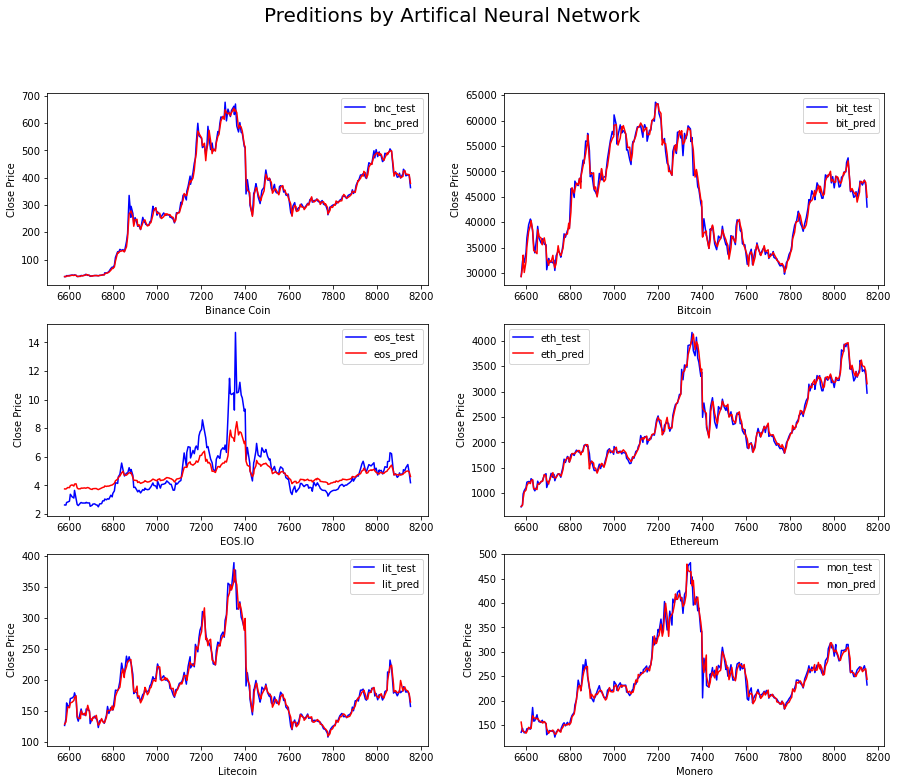

In [69]:
# visualize the prediction of neural network for each cryptocurrency in 2021
fig = plt.figure(figsize=(15,12))
fig.add_subplot(321)
plt.plot(times, y_bnc_test, 'b', label='bnc_test')
plt.plot(times, y_pred_nn_bnc, 'r', label='bnc_pred')
plt.legend()
plt.xlabel('Binance Coin')
plt.ylabel('Close Price')

fig.add_subplot(322)
plt.plot(times, y_bit_test, 'b', label='bit_test')
plt.plot(times, y_pred_nn_bit, 'r', label='bit_pred')
plt.legend()
plt.xlabel('Bitcoin')
plt.ylabel('Close Price')

fig.add_subplot(323)
plt.plot(times, y_eos_test, 'b', label='eos_test')
plt.plot(times, y_pred_nn_eos, 'r', label='eos_pred')
plt.legend()
plt.xlabel('EOS.IO')
plt.ylabel('Close Price')

fig.add_subplot(324)
plt.plot(times, y_eth_test, 'b', label='eth_test')
plt.plot(times, y_pred_nn_eth, 'r', label='eth_pred')
plt.legend()
plt.xlabel('Ethereum')
plt.ylabel('Close Price')

fig.add_subplot(325)
plt.plot(times, y_lit_test, 'b', label='lit_test')
plt.plot(times, y_pred_nn_lit, 'r', label='lit_pred')
plt.legend()
plt.xlabel('Litecoin')
plt.ylabel('Close Price')

fig.add_subplot(326)
plt.plot(times, y_mon_test, 'b', label='mon_test')
plt.plot(times, y_pred_nn_mon, 'r', label='mon_pred')
plt.legend()
plt.xlabel('Monero')
plt.ylabel('Close Price')

plt.suptitle('Preditions by Artifical Neural Network',fontsize=20)
plt.show()